#### Унитарное кодирование

Преобразование категориального признака в несколько бинарных признаков

#### Загрузка набора данных Titanic

In [1]:
import pandas as pd

titanic = pd.read_csv("data/titanic.csv", index_col="PassengerId")

titanic

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


#### Унитарное кодирование признаков Пол (Sex) и Порт посадки (Embarked)

Кодирование

In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder(sparse_output=False, drop="first")

encoded_values = encoder.fit_transform(titanic[["Embarked", "Sex"]])

encoded_columns = encoder.get_feature_names_out(["Embarked", "Sex"])

encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)

encoded_values_df

,Embarked_Q,Embarked_S,Embarked_nan,Sex_male
0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0
...,...,...,...,...
886,0.0,1.0,0.0,1.0
887,0.0,1.0,0.0,0.0
888,0.0,1.0,0.0,0.0
889,0.0,0.0,0.0,1.0


Добавление признаков в исходный Dataframe

In [3]:
titanic = pd.concat([titanic, encoded_values_df], axis=1)

titanic

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S,Embarked_nan,Sex_male
1,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,0.0,0.0,0.0,0.0
2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,0.0,1.0,0.0,0.0
3,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0,0.0,0.0
4,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,0.0,1.0,0.0,1.0
5,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,1.0,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S,0.0,1.0,0.0,0.0
889,0.0,3.0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1.0,2.0,W./C. 6607,23.4500,NaN,S,0.0,0.0,0.0,1.0
890,1.0,1.0,"Behr, Mr. Karl Howell",male,26.0,0.0,0.0,111369,30.0000,C148,C,1.0,0.0,0.0,1.0
891,0.0,3.0,"Dooley, Mr. Patrick",male,32.0,0.0,0.0,370376,7.7500,NaN,Q,NaN,NaN,NaN,NaN


#### Дискретизация признаков

Равномерное разделение данных на 3 группы

In [4]:
labels = ["young", "middle-aged", "old"]
num_bins = 3

In [5]:
hist1, bins1 = np.histogram(titanic["Age"].fillna(titanic["Age"].median()), bins=num_bins)
bins1, hist1

(array([ 0.42      , 26.94666667, 53.47333333, 80.        ]),
 array([319, 523,  50]))

In [6]:
pd.concat([titanic["Age"], pd.cut(titanic["Age"], list(bins1))], axis=1).head(20)

,Age,Age
1,22.0,"(0.42, 26.947]"
2,38.0,"(26.947, 53.473]"
3,26.0,"(0.42, 26.947]"
4,35.0,"(26.947, 53.473]"
5,35.0,"(26.947, 53.473]"
6,NaN,NaN
7,54.0,"(53.473, 80.0]"
8,2.0,"(0.42, 26.947]"
9,27.0,"(26.947, 53.473]"
10,14.0,"(0.42, 26.947]"


In [7]:
pd.concat([titanic["Age"], pd.cut(titanic["Age"], list(bins1), labels=labels)], axis=1).head(20)

,Age,Age
1,22.0,young
2,38.0,middle-aged
3,26.0,young
4,35.0,middle-aged
5,35.0,middle-aged
6,NaN,NaN
7,54.0,old
8,2.0,young
9,27.0,middle-aged
10,14.0,young


Равномерное разделение данных на 3 группы c установкой собственной границы диапазона значений (от 0 до 100)

In [8]:
bins2 = np.linspace(0, 100, 4)
tmp_bins2 = np.digitize(titanic["Age"].fillna(titanic["Age"].median()), bins2)
hist2 = np.bincount(tmp_bins2 - 1)
bins2, hist2

(array([  0.        ,  33.33333333,  66.66666667, 100.        ]),
 array([641, 244,   7]))

In [9]:
pd.concat([titanic["Age"], pd.cut(titanic["Age"], list(bins2))], axis=1).head(20)

,Age,Age
1,22.0,"(0.0, 33.333]"
2,38.0,"(33.333, 66.667]"
3,26.0,"(0.0, 33.333]"
4,35.0,"(33.333, 66.667]"
5,35.0,"(33.333, 66.667]"
6,NaN,NaN
7,54.0,"(33.333, 66.667]"
8,2.0,"(0.0, 33.333]"
9,27.0,"(0.0, 33.333]"
10,14.0,"(0.0, 33.333]"


In [10]:
pd.concat([titanic["Age"], pd.cut(titanic["Age"], list(bins2), labels=labels)], axis=1).head(20)

,Age,Age
1,22.0,young
2,38.0,middle-aged
3,26.0,young
4,35.0,middle-aged
5,35.0,middle-aged
6,NaN,NaN
7,54.0,middle-aged
8,2.0,young
9,27.0,young
10,14.0,young


Равномерное разделение данных на 3 группы c установкой собственных интервалов (0 - 39, 40 - 60, 61 - 100)

In [11]:
hist3, bins3 = np.histogram(
    titanic["Age"].fillna(titanic["Age"].median()), bins=[0, 40, 60, 100]
)
bins3, hist3

(array([  0,  40,  60, 100]), array([729, 137,  26]))

In [12]:
pd.concat([titanic["Age"], pd.cut(titanic["Age"], list(bins3))], axis=1).head(20)

,Age,Age
1,22.0,"(0.0, 40.0]"
2,38.0,"(0.0, 40.0]"
3,26.0,"(0.0, 40.0]"
4,35.0,"(0.0, 40.0]"
5,35.0,"(0.0, 40.0]"
6,NaN,NaN
7,54.0,"(40.0, 60.0]"
8,2.0,"(0.0, 40.0]"
9,27.0,"(0.0, 40.0]"
10,14.0,"(0.0, 40.0]"


In [13]:
pd.concat([titanic["Age"], pd.cut(titanic["Age"], list(bins3), labels=labels)], axis=1).head(20)

,Age,Age
1,22.0,young
2,38.0,young
3,26.0,young
4,35.0,young
5,35.0,young
6,NaN,NaN
7,54.0,middle-aged
8,2.0,young
9,27.0,young
10,14.0,young


Квантильное разделение данных на 3 группы

In [14]:
pd.concat([titanic["Age"], pd.qcut(titanic["Age"], q=3, labels=False)], axis=1).head(20)

,Age,Age
1,22.0,0.0
2,38.0,2.0
3,26.0,1.0
4,35.0,2.0
5,35.0,2.0
6,NaN,NaN
7,54.0,2.0
8,2.0,0.0
9,27.0,1.0
10,14.0,0.0


In [15]:
pd.concat([titanic["Age"], pd.qcut(titanic["Age"], q=3, labels=labels)], axis=1).head(20)

,Age,Age
1,22.0,young
2,38.0,old
3,26.0,middle-aged
4,35.0,old
5,35.0,old
6,NaN,NaN
7,54.0,old
8,2.0,young
9,27.0,middle-aged
10,14.0,young


#### Пример конструирования признаков на основе существующих

Title - обращение к пассажиру (Mr, Mrs, Miss)

Is_married - замужняя ли женщина

Cabin_type - палуба (тип каюты)

In [16]:
titanic_cl = titanic.drop(
    ["Embarked_Q", "Embarked_S", "Embarked_nan", "Sex_male"], axis=1, errors="ignore"
)
titanic_cl = titanic_cl.dropna()

titanic_cl["Title"] = [
    i.split(",")[1].split(".")[0].strip() for i in titanic_cl["Name"]
]

titanic_cl["Is_married"] = [1 if i == "Mrs" else 0 for i in titanic_cl["Title"]]

titanic_cl["Cabin_type"] = [i[0] for i in titanic_cl["Cabin"]]

titanic_cl

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Is_married,Cabin_type
2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,Mrs,1,C
4,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,Mrs,1,C
7,0.0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S,Mr,0,E
11,1.0,3.0,"Sandstrom, Miss. Marguerite Rut",female,4.0,1.0,1.0,PP 9549,16.7000,G6,S,Miss,0,G
12,1.0,1.0,"Bonnell, Miss. Elizabeth",female,58.0,0.0,0.0,113783,26.5500,C103,S,Miss,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,1.0,1.0,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1.0,1.0,11751,52.5542,D35,S,Mrs,1,D
873,0.0,1.0,"Carlsson, Mr. Frans Olof",male,33.0,0.0,0.0,695,5.0000,B51 B53 B55,S,Mr,0,B
880,1.0,1.0,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0.0,1.0,11767,83.1583,C50,C,Mrs,1,C
888,1.0,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S,Miss,0,B


#### Пример использования библиотеки Featuretools для автоматического конструирования (синтеза) признаков

https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html

#### Загрузка данных

За основу был взят набор данных "Ecommerce Orders Data Set" из Kaggle

Используется только 100 первых заказов и связанные с ними объекты

https://www.kaggle.com/datasets/sangamsharmait/ecommerce-orders-data-analysis

In [17]:
import featuretools as ft
from woodwork.logical_types import Categorical, Datetime

customers = pd.read_csv("data/orders/customers.csv")
sellers = pd.read_csv("data/orders/sellers.csv")
products = pd.read_csv("data/orders/products.csv")
orders = pd.read_csv("data/orders/orders.csv")
orders.fillna({"order_delivered_carrier_date": pd.to_datetime(
    "1900-01-01 00:00:00"
)}, inplace=True)
orders.fillna(
    {"order_delivered_customer_date": pd.to_datetime("1900-01-01 00:00:00")},
    inplace=True,
)
order_items = pd.read_csv("data/orders/order_items.csv")

#### Создание сущностей в featuretools

Добавление dataframe'ов с данными в EntitySet с указанием параметров: название сущности (таблицы), первичный ключ, категориальные атрибуты (в том числе даты)

In [18]:
es = ft.EntitySet(id="orders")

es = es.add_dataframe(
    dataframe_name="customers",
    dataframe=customers,
    index="customer_id",
    logical_types={
        "customer_unique_id": Categorical,
        "customer_zip_code_prefix": Categorical,
        "customer_city": Categorical,
        "customer_state": Categorical,
    },
)
es = es.add_dataframe(
    dataframe_name="sellers",
    dataframe=sellers,
    index="seller_id",
    logical_types={
        "seller_zip_code_prefix": Categorical,
        "seller_city": Categorical,
        "seller_state": Categorical,
    },
)
es = es.add_dataframe(
    dataframe_name="products",
    dataframe=products,
    index="product_id",
    logical_types={
        "product_category_name": Categorical,
        "product_name_lenght": Categorical,
        "product_description_lenght": Categorical,
        "product_photos_qty": Categorical,
    },
)
es = es.add_dataframe(
    dataframe_name="orders",
    dataframe=orders,
    index="order_id",
    logical_types={
        "order_status": Categorical,
        "order_purchase_timestamp": Datetime,
        "order_approved_at": Datetime,
        "order_delivered_carrier_date": Datetime,
        "order_delivered_customer_date": Datetime,
        "order_estimated_delivery_date": Datetime,
    },
)
es = es.add_dataframe(
    dataframe_name="order_items",
    dataframe=order_items,
    index="orderitem_id",
    make_index=True,
    logical_types={"shipping_limit_date": Datetime},
)

es

c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, s

Entityset: orders
  DataFrames:
    customers [Rows: 100, Columns: 5]
    sellers [Rows: 87, Columns: 4]
    products [Rows: 100, Columns: 9]
    orders [Rows: 100, Columns: 8]
    order_items [Rows: 115, Columns: 8]
  Relationships:
    No relationships

#### Настройка связей между сущностями featuretools

Настройка связей между таблицами на уровне ключей

Связь указывается от родителя к потомкам (таблица-родитель, первичный ключ, таблица-потомок, внешний ключ)

In [19]:
es = es.add_relationship("customers", "customer_id", "orders", "customer_id")
es = es.add_relationship("orders", "order_id", "order_items", "order_id")
es = es.add_relationship("products", "product_id", "order_items", "product_id")
es = es.add_relationship("sellers", "seller_id", "order_items", "seller_id")

es

Entityset: orders
  DataFrames:
    customers [Rows: 100, Columns: 5]
    sellers [Rows: 87, Columns: 4]
    products [Rows: 100, Columns: 9]
    orders [Rows: 100, Columns: 8]
    order_items [Rows: 115, Columns: 8]
  Relationships:
    orders.customer_id -> customers.customer_id
    order_items.order_id -> orders.order_id
    order_items.product_id -> products.product_id
    order_items.seller_id -> sellers.seller_id

#### Автоматическое конструирование признаков с помощью featuretools

Библиотека применят различные функции агрегации и трансформации к атрибутам таблицы order_items с учетом отношений

Результат помещается в Dataframe feature_matrix

In [20]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="order_items",
    agg_primitives=["mean", "count", "mode", "any"],
    trans_primitives=["hour", "weekday"],
    max_depth=2,
)

feature_matrix

c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['any', 'mode']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)
c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x000001B043C53600> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
c:\Users\user\Projects\python\mai\.venv\Lib\site-packages\featuretoo

,order_item_id,price,freight_value,HOUR(shipping_limit_date),WEEKDAY(shipping_limit_date),orders.order_status,products.product_category_name,products.product_name_lenght,products.product_description_lenght,products.product_photos_qty,...,orders.customers.customer_city,orders.customers.customer_state,products.COUNT(order_items),products.MEAN(order_items.freight_value),products.MEAN(order_items.order_item_id),products.MEAN(order_items.price),sellers.COUNT(order_items),sellers.MEAN(order_items.freight_value),sellers.MEAN(order_items.order_item_id),sellers.MEAN(order_items.price)
orderitem_id,,,,,,,,,,,,,,,,,,,,,
0,1,38.50,24.84,20,4,delivered,cama_mesa_banho,53.0,223.0,1.0,...,santa luzia,PB,1,24.84,1.0,38.50,2,21.340,1.0,61.200000
1,1,29.99,7.39,8,0,delivered,telefonia,59.0,675.0,5.0,...,sao paulo,SP,1,7.39,1.0,29.99,1,7.390,1.0,29.990000
2,1,110.99,21.27,21,1,delivered,cama_mesa_banho,52.0,413.0,1.0,...,gravatai,RS,1,21.27,1.0,110.99,1,21.270,1.0,110.990000
3,1,27.99,15.10,23,1,delivered,telefonia,60.0,818.0,6.0,...,imbituba,SC,1,15.10,1.0,27.99,2,13.970,1.0,26.490000
4,1,49.90,16.05,13,2,invoiced,NaN,NaN,NaN,NaN,...,santa rosa,RS,1,16.05,1.0,49.90,1,16.050,1.0,49.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1,17.90,10.96,8,1,delivered,cama_mesa_banho,55.0,122.0,1.0,...,jundiai,SP,1,10.96,1.0,17.90,1,10.960,1.0,17.900000
111,1,79.99,8.91,9,4,delivered,beleza_saude,59.0,492.0,3.0,...,sao paulo,SP,1,8.91,1.0,79.99,5,13.206,1.2,54.590000
112,1,190.00,19.41,13,3,delivered,climatizacao,60.0,3270.0,4.0,...,paulinia,SP,1,19.41,1.0,190.00,1,19.410,1.0,190.000000


#### Полученные признаки

Список колонок полученного dataframe'а

In [21]:
feature_defs

[<Feature: order_item_id>,
 <Feature: price>,
 <Feature: freight_value>,
 <Feature: HOUR(shipping_limit_date)>,
 <Feature: WEEKDAY(shipping_limit_date)>,
 <Feature: orders.order_status>,
 <Feature: products.product_category_name>,
 <Feature: products.product_name_lenght>,
 <Feature: products.product_description_lenght>,
 <Feature: products.product_photos_qty>,
 <Feature: products.product_weight_g>,
 <Feature: products.product_length_cm>,
 <Feature: products.product_height_cm>,
 <Feature: products.product_width_cm>,
 <Feature: sellers.seller_zip_code_prefix>,
 <Feature: sellers.seller_city>,
 <Feature: sellers.seller_state>,
 <Feature: orders.COUNT(order_items)>,
 <Feature: orders.MEAN(order_items.freight_value)>,
 <Feature: orders.MEAN(order_items.order_item_id)>,
 <Feature: orders.MEAN(order_items.price)>,
 <Feature: orders.HOUR(order_approved_at)>,
 <Feature: orders.HOUR(order_delivered_carrier_date)>,
 <Feature: orders.HOUR(order_delivered_customer_date)>,
 <Feature: orders.HOUR(ord

#### Отсечение значений признаков

Определение выбросов с помощью boxplot

<Axes: >

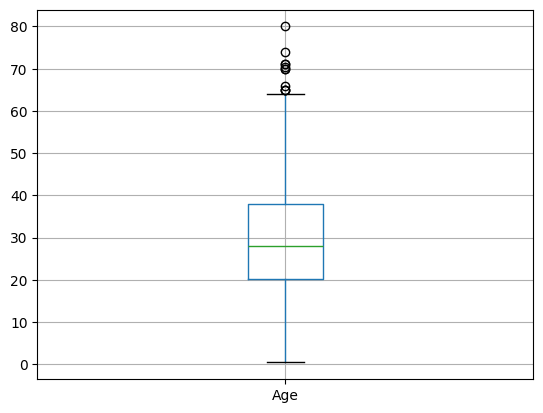

In [22]:
titanic.boxplot(column="Age")

Отсечение данных для признака Возраст, значение которых больше 65 лет

In [23]:
titanic_norm = titanic.copy()

titanic_norm["AgeClip"] = titanic["Age"].clip(0, 65);

titanic_norm[titanic_norm["Age"] > 65][["Name", "Age", "AgeClip"]]

,Name,Age,AgeClip
34,"Wheadon, Mr. Edward H",66.0,65.0
97,"Goldschmidt, Mr. George B",71.0,65.0
117,"Connors, Mr. Patrick",70.5,65.0
494,"Artagaveytia, Mr. Ramon",71.0,65.0
631,"Barkworth, Mr. Algernon Henry Wilson",80.0,65.0
673,"Mitchell, Mr. Henry Michael",70.0,65.0
746,"Crosby, Capt. Edward Gifford",70.0,65.0
852,"Svensson, Mr. Johan",74.0,65.0


Винсоризация признака Возраст

In [24]:
from scipy.stats.mstats import winsorize

print(titanic_norm["Age"].quantile(q=0.95))

titanic_norm["AgeWinsorize"] = winsorize(
    titanic_norm["Age"].fillna(titanic_norm["Age"].mean()), (0, 0.05), inplace=False
)

titanic_norm[titanic_norm["Age"] > 65][["Name", "Age", "AgeWinsorize"]]

56.0


,Name,Age,AgeWinsorize
34,"Wheadon, Mr. Edward H",66.0,54.0
97,"Goldschmidt, Mr. George B",71.0,54.0
117,"Connors, Mr. Patrick",70.5,54.0
494,"Artagaveytia, Mr. Ramon",71.0,54.0
631,"Barkworth, Mr. Algernon Henry Wilson",80.0,54.0
673,"Mitchell, Mr. Henry Michael",70.0,54.0
746,"Crosby, Capt. Edward Gifford",70.0,54.0
852,"Svensson, Mr. Johan",74.0,54.0


#### Нормализация значений

In [25]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler_2 = preprocessing.MinMaxScaler(feature_range=(-1, 1))

titanic_norm["AgeNorm"] = min_max_scaler.fit_transform(
    titanic_norm["Age"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm["AgeClipNorm"] = min_max_scaler.fit_transform(
    titanic_norm["AgeClip"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm["AgeWinsorizeNorm"] = min_max_scaler.fit_transform(
    titanic_norm["AgeWinsorize"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm["AgeWinsorizeNorm2"] = min_max_scaler_2.fit_transform(
    titanic_norm["AgeWinsorize"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm[
    ["Name", "Age", "AgeNorm", "AgeClipNorm", "AgeWinsorizeNorm", "AgeWinsorizeNorm2"]
].head(20)

,Name,Age,AgeNorm,AgeClipNorm,AgeWinsorizeNorm,AgeWinsorizeNorm2
1,"Braund, Mr. Owen Harris",22.0,0.271174,0.334159,0.402762,-0.194476
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,0.472229,0.581914,0.701381,0.402762
3,"Heikkinen, Miss. Laina",26.0,0.321438,0.396098,0.477417,-0.045166
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,0.434531,0.535460,0.645390,0.290780
5,"Allen, Mr. William Henry",35.0,0.434531,0.535460,0.645390,0.290780
6,"Moran, Mr. James",NaN,NaN,NaN,0.546456,0.092912
7,"McCarthy, Mr. Timothy J",54.0,0.673285,0.829669,1.000000,1.000000
8,"Palsson, Master. Gosta Leonard",2.0,0.019854,0.024466,0.029489,-0.941023
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0.334004,0.411583,0.496081,-0.007839
10,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,0.170646,0.210282,0.253453,-0.493094


#### Стандартизация значений

In [26]:
from sklearn import preprocessing

stndart_scaler = preprocessing.StandardScaler()

titanic_norm["AgeStand"] = stndart_scaler.fit_transform(
    titanic_norm["Age"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm["AgeClipStand"] = stndart_scaler.fit_transform(
    titanic_norm["AgeClip"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm["AgeWinsorizeStand"] = stndart_scaler.fit_transform(
    titanic_norm["AgeWinsorize"].to_numpy().reshape(-1, 1)
).reshape(titanic_norm["Age"].shape)

titanic_norm[["Name", "Age", "AgeStand", "AgeClipStand", "AgeWinsorizeStand"]].head(20)

,Name,Age,AgeStand,AgeClipStand,AgeWinsorizeStand
1,"Braund, Mr. Owen Harris",22.0,-0.530377,-0.532745,-0.606602
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,0.571831,0.585060,0.718863
3,"Heikkinen, Miss. Laina",26.0,-0.254825,-0.253294,-0.275236
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,0.365167,0.375472,0.470339
5,"Allen, Mr. William Henry",35.0,0.365167,0.375472,0.470339
6,"Moran, Mr. James",NaN,NaN,NaN,0.031205
7,"McCarthy, Mr. Timothy J",54.0,1.674039,1.702866,2.044329
8,"Palsson, Master. Gosta Leonard",2.0,-1.908136,-1.930003,-2.263435
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,-0.185937,-0.183431,-0.192394
10,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,-1.081480,-1.091648,-1.269335
